# 导入必要的库

In [25]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '5'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from tensorboardX import SummaryWriter

import random
import shutil
from glob import glob
from tqdm import tqdm

from utils import *
from models import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def rmrf(path):
    try:
        shutil.rmtree(path)
    except:
        pass

for f in glob('runs/*/.AppleDouble'):
    rmrf(f)

rmrf('runs/metanet')
rmrf('runs/transform_net')

# 搭建模型

In [3]:
vgg16 = models.vgg16(pretrained=True)
vgg16 = VGG(vgg16.features[:23]).to(device).eval()

In [4]:
base = 32
transform_net = TransformNet(base).to(device)
transform_net.get_param_dict()

defaultdict(int,
            {'downsampling.5': 18496,
             'downsampling.9': 73856,
             'residuals.0.conv.1': 147584,
             'residuals.0.conv.5': 147584,
             'residuals.1.conv.1': 147584,
             'residuals.1.conv.5': 147584,
             'residuals.2.conv.1': 147584,
             'residuals.2.conv.5': 147584,
             'residuals.3.conv.1': 147584,
             'residuals.3.conv.5': 147584,
             'residuals.4.conv.1': 147584,
             'residuals.4.conv.5': 147584,
             'upsampling.2': 73792,
             'upsampling.7': 18464})

In [5]:
transform_net

TransformNet(
  (downsampling): Sequential(
    (0): ReflectionPad2d((4, 4, 4, 4))
    (1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
    (2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU()
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): MyConv2D(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (6): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): ReLU()
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): MyConv2D(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (10): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (11): ReLU()
  )
  (residuals): Sequential(
    (0): ResidualBlock(
      (conv): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): MyConv2D(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU()
        (4): Re

In [6]:
class MetaNet(nn.Module):
    def __init__(self, param_dict):
        super(MetaNet, self).__init__()
        self.param_num = len(param_dict)
        self.hidden = nn.Linear(1920, 128*self.param_num)
        self.fc_dict = {}
        for i, (name, params) in enumerate(param_dict.items()):
            self.fc_dict[name] = i
            setattr(self, 'fc{}'.format(i+1), nn.Linear(128, params))
    
    # ONNX 要求输出 tensor 或者 list，不能是 dict
    def forward(self, mean_std_features):
        hidden = F.relu(self.hidden(mean_std_features))
        filters = {}
        for name, i in self.fc_dict.items():
            fc = getattr(self, 'fc{}'.format(i+1))
            filters[name] = fc(hidden[:,i*128:(i+1)*128])
        return list(filters.values())
    
    def forward2(self, mean_std_features):
        hidden = F.relu(self.hidden(mean_std_features))
        filters = {}
        for name, i in self.fc_dict.items():
            fc = getattr(self, 'fc{}'.format(i+1))
            filters[name] = fc(hidden[:,i*128:(i+1)*128])
        return filters

In [7]:
metanet = MetaNet(transform_net.get_param_dict()).to(device)

In [8]:
metanet

MetaNet(
  (hidden): Linear(in_features=1920, out_features=1792, bias=True)
  (fc1): Linear(in_features=128, out_features=18496, bias=True)
  (fc2): Linear(in_features=128, out_features=73856, bias=True)
  (fc3): Linear(in_features=128, out_features=147584, bias=True)
  (fc4): Linear(in_features=128, out_features=147584, bias=True)
  (fc5): Linear(in_features=128, out_features=147584, bias=True)
  (fc6): Linear(in_features=128, out_features=147584, bias=True)
  (fc7): Linear(in_features=128, out_features=147584, bias=True)
  (fc8): Linear(in_features=128, out_features=147584, bias=True)
  (fc9): Linear(in_features=128, out_features=147584, bias=True)
  (fc10): Linear(in_features=128, out_features=147584, bias=True)
  (fc11): Linear(in_features=128, out_features=147584, bias=True)
  (fc12): Linear(in_features=128, out_features=147584, bias=True)
  (fc13): Linear(in_features=128, out_features=73792, bias=True)
  (fc14): Linear(in_features=128, out_features=18464, bias=True)
)

# 输出计算图到 tensorboard

In [9]:
mean_std_features = torch.rand(4, 1920).to(device)
writer = SummaryWriter('runs/metanet')
writer.add_graph(metanet, (mean_std_features, ))

rands = torch.rand(4, 3, 256, 256).to(device)
writer = SummaryWriter('runs/transform_net')
writer.add_graph(transform_net, (rands, ))

# 测试速度

In [10]:
metanet.load_state_dict(torch.load('models/metanet_base32_style50_tv1e-06_tagnohvd.pth'))
transform_net.load_state_dict(torch.load('models/metanet_base32_style50_tv1e-06_tagnohvd_transform_net.pth'))

In [11]:
X = torch.rand((1, 3, 256, 256)).to(device)

In [12]:
%%time
for i in range(1000):
    features = vgg16(X)
    mean_std_features = mean_std(features)
    weights = metanet.forward2(mean_std_features)
    transform_net.set_weights(weights)
    del features, mean_std_features, weights

CPU times: user 6.27 s, sys: 2.44 s, total: 8.72 s
Wall time: 8.72 s


In [13]:
%%time
for i in range(1000):
    transform_net(X)

CPU times: user 4.07 s, sys: 588 ms, total: 4.66 s
Wall time: 4.65 s


In [14]:
%%time
for i in range(1000):
    features = vgg16(X)
    mean_std_features = mean_std(features)
    weights = metanet.forward2(mean_std_features)
    transform_net.set_weights(weights)
    transform_net(X)
    del features, mean_std_features, weights

CPU times: user 10.4 s, sys: 2.97 s, total: 13.4 s
Wall time: 13.4 s


# 可视化

In [15]:
width = 256

data_transform = transforms.Compose([
    transforms.RandomResizedCrop(width, scale=(256/480, 1), ratio=(1, 1)), 
    transforms.ToTensor(), 
    tensor_normalizer
])

style_dataset = torchvision.datasets.ImageFolder('/home/ypw/WikiArt/', transform=data_transform)
content_dataset = torchvision.datasets.ImageFolder('/home/ypw/COCO/', transform=data_transform)

In [16]:
# epoch = 19
# metanet.load_state_dict(torch.load(
#     f'checkpoints/metanet_base32_style50_tv1e-06_tag1_{epoch}.pth'))
# transform_net.load_state_dict(torch.load(
#     f'checkpoints/metanet_base32_style50_tv1e-06_tag1_transform_net_{epoch}.pth'))

In [29]:
style_weight = 50
content_weight = 1
tv_weight = 1e-6
batch_size = 8

trainable_params = {}
trainable_param_shapes = {}
for model in [vgg16, transform_net, metanet]:
    for name, param in model.named_parameters():
        if param.requires_grad:
            trainable_params[name] = param
            trainable_param_shapes[name] = param.shape

optimizer = optim.Adam(trainable_params.values(), 1e-3)
content_data_loader = torch.utils.data.DataLoader(content_dataset, batch_size=batch_size, shuffle=True)

21it [00:06,  3.44it/s]                        


(256, 256, 3)
(256, 1024, 3)
(256, 1024, 3)


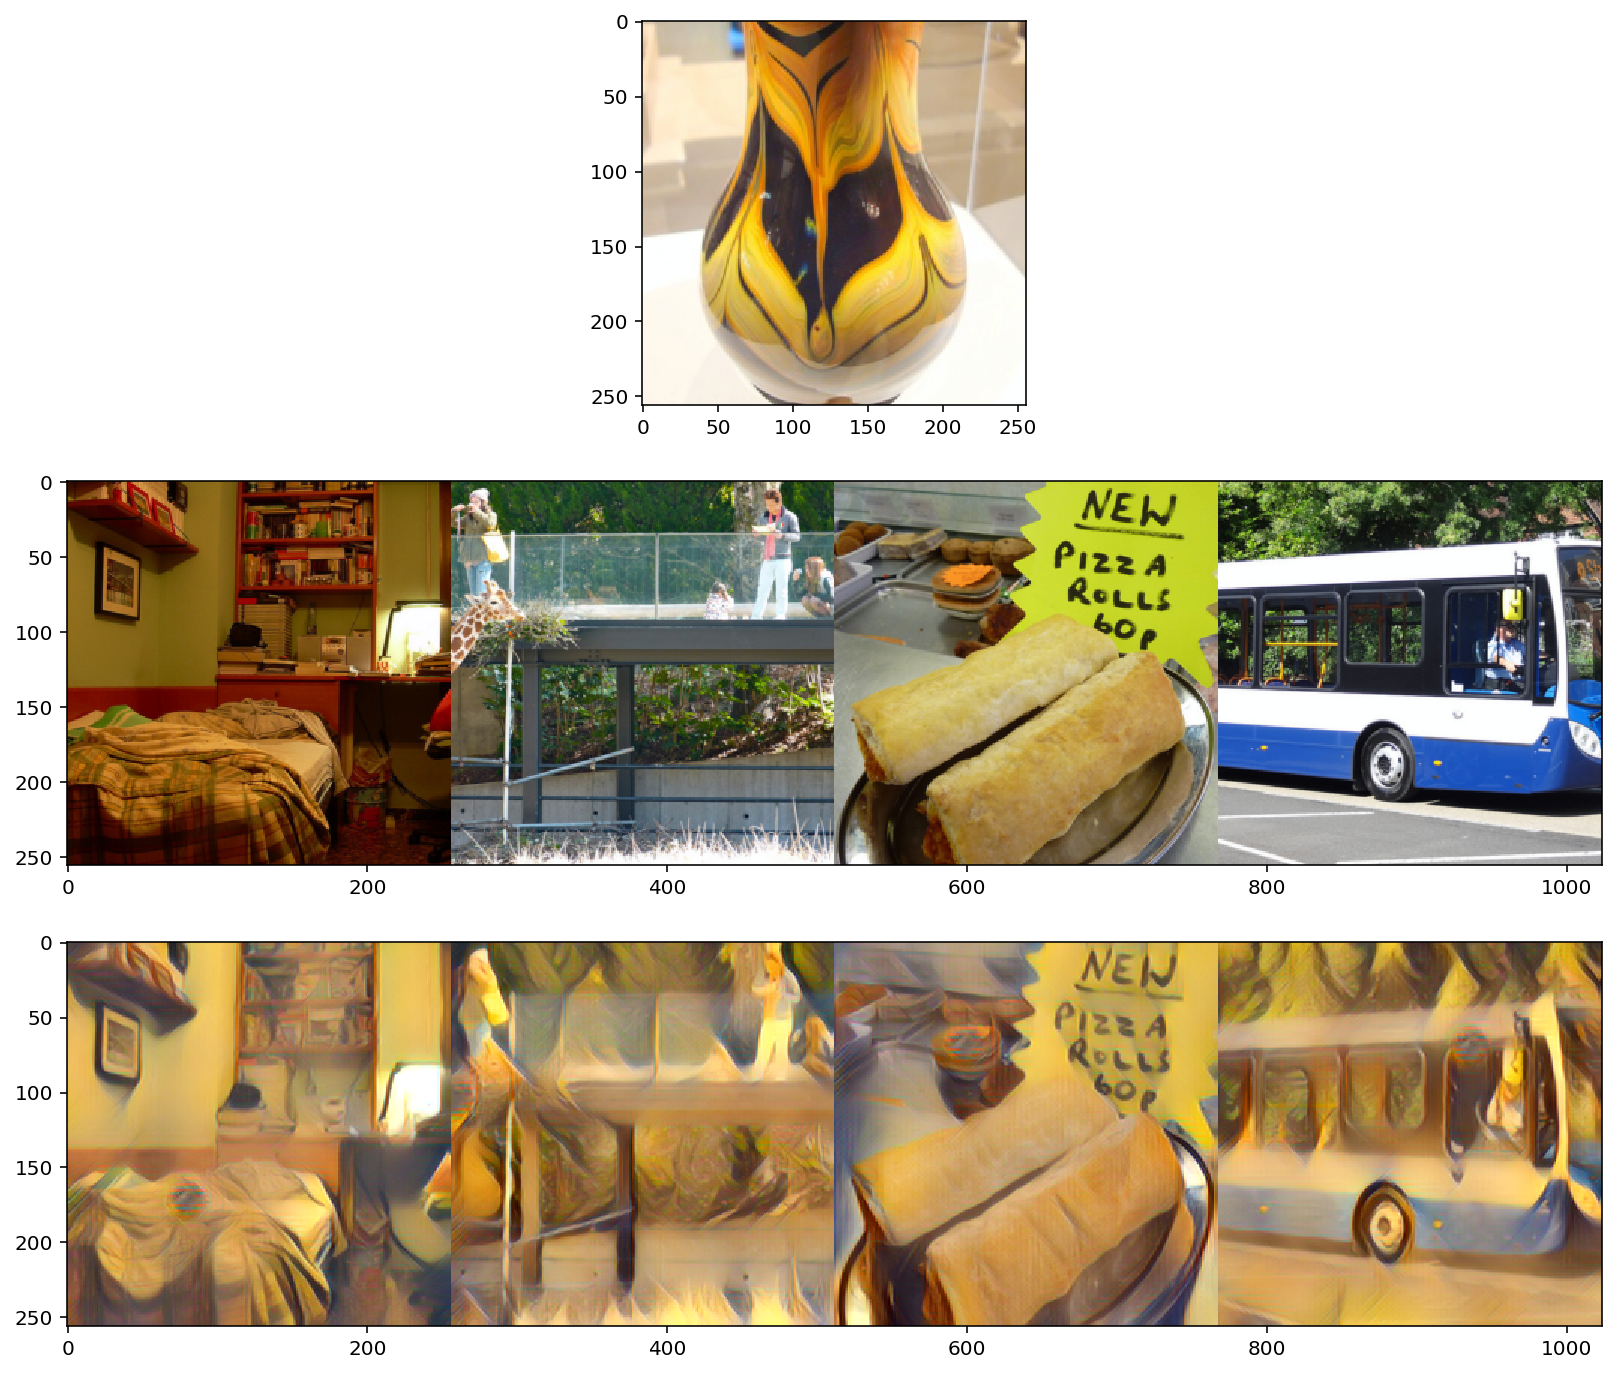

In [41]:
style_image = read_image('../images/test.jpg', target_width=256).to(device)
style_features = vgg16(style_image)
style_mean_std = mean_std(style_features)

metanet.load_state_dict(torch.load('models/metanet_base32_style50_tv1e-06_tagnohvd.pth'))
transform_net.load_state_dict(torch.load('models/metanet_base32_style50_tv1e-06_tagnohvd_transform_net.pth'))

n_batch = 20
with tqdm(enumerate(content_data_loader), total=n_batch) as pbar:
    for batch, (content_images, _) in pbar:
        x = content_images.cpu().numpy()
        if (x.min(-1).min(-1) == x.max(-1).max(-1)).any():
            continue
        
        optimizer.zero_grad()
        
        # 使用风格图像生成风格模型
        weights = metanet.forward2(mean_std(style_features))
        transform_net.set_weights(weights, 0)

        # 使用风格模型预测风格迁移图像
        content_images = content_images.to(device)
        transformed_images = transform_net(content_images)

        # 使用 vgg16 计算特征
        content_features = vgg16(content_images)
        transformed_features = vgg16(transformed_images)
        transformed_mean_std = mean_std(transformed_features)

        # content loss
        content_loss = content_weight * F.mse_loss(transformed_features[2], content_features[2])

        # style loss
        style_loss = style_weight * F.mse_loss(transformed_mean_std, 
                                               style_mean_std.expand_as(transformed_mean_std))

        # total variation loss
        y = transformed_images
        tv_loss = tv_weight * (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
                                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

        # 求和
        loss = content_loss + style_loss + tv_loss 

        loss.backward()
        optimizer.step()
        
        if batch > n_batch:
            break

content_images = torch.stack([random.choice(content_dataset)[0] for i in range(4)]).to(device)
# while content_images.min() < -2:
#     print('.', end=' ')
#     content_images = torch.stack([random.choice(content_dataset)[0] for i in range(4)]).to(device)
transformed_images = transform_net(content_images)

transformed_images_vis = torch.cat([x for x in transformed_images], dim=-1)
content_images_vis = torch.cat([x for x in content_images], dim=-1)


plt.figure(figsize=(20, 12))
plt.subplot(3, 1, 1)
imshow(style_image)
plt.subplot(3, 1, 2)
imshow(content_images_vis)
plt.subplot(3, 1, 3)
imshow(transformed_images_vis)

(256, 256, 3)
(256, 1024, 3)
(256, 1024, 3)


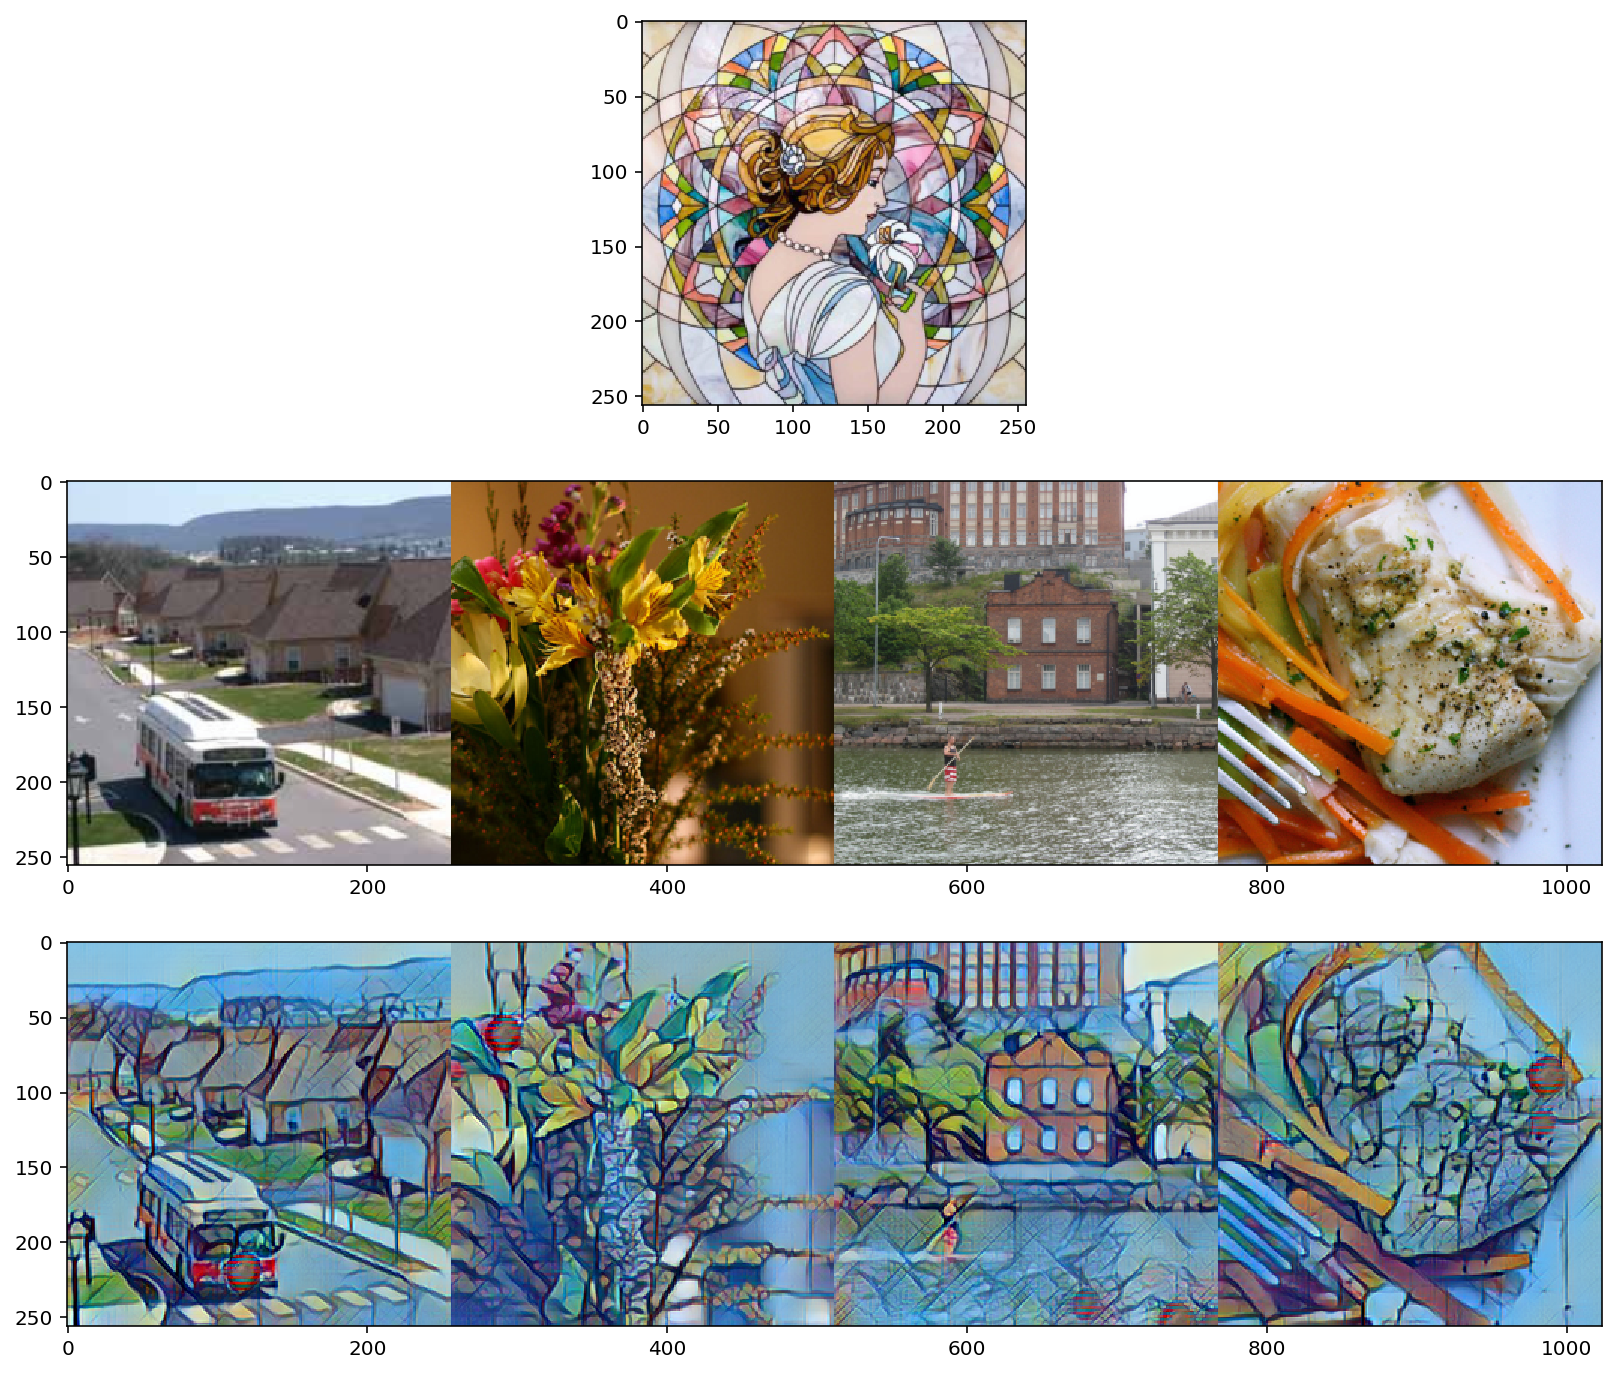

In [38]:
# style_image = random.choice(style_dataset)[0].unsqueeze(0).to(device)
style_image = read_image('../images/mosaic.jpg', target_width=256).to(device)
# style_image = style_image[:,[2, 1, 0]]
features = vgg16(style_image)
mean_std_features = mean_std(features)
weights = metanet.forward2(mean_std_features)
transform_net.set_weights(weights)

content_images = torch.stack([random.choice(content_dataset)[0] for i in range(4)]).to(device)
# while content_images.min() < -2:
#     print('.', end=' ')
#     content_images = torch.stack([random.choice(content_dataset)[0] for i in range(4)]).to(device)
transformed_images = transform_net(content_images)

transformed_images_vis = torch.cat([x for x in transformed_images], dim=-1)
content_images_vis = torch.cat([x for x in content_images], dim=-1)


plt.figure(figsize=(20, 12))
plt.subplot(3, 1, 1)
imshow(style_image)
plt.subplot(3, 1, 2)
imshow(content_images_vis)
plt.subplot(3, 1, 3)
imshow(transformed_images_vis)